In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
from scipy import stats

from torch.utils.data import random_split

from statsforecast import StatsForecast

/home/atleeri/repositories/forecast-electricity-markets/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveMean,
    NaiveDrift,
    ExponentialSmoothing,
    AutoARIMA,
    ARIMA,
    Theta,
    FFT
)

from darts.metrics import mase, mse, mae, ope

from darts.utils.statistics import plot_acf, check_seasonality

The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


Change working directory

In [3]:
notebook_path = %pwd

os.chdir(Path(notebook_path).parent)
os.getcwd()

'/home/atleeri/repositories/forecast-electricity-markets'

Load processed data

In [4]:
processed_data_dir = Path('data/processed')
filepaths = list(processed_data_dir.glob('**/*60*.parquet'))
filepaths

[PosixPath('data/processed/opsd-time_series-2020-10-06/time_series_60min_singleindex.parquet')]

In [5]:
filepath = filepaths[0]
df = pd.read_parquet(filepath)
df

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,8852.0,NaN
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,9054.0,NaN
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,9070.0,NaN
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,9163.0,NaN
...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30 20:00:00+01:00,10654.0,49.92
50397,2020-09-30 20:00:00+00:00,2020-09-30 21:00:00+01:00,11836.0,42.79
50398,2020-09-30 21:00:00+00:00,2020-09-30 22:00:00+01:00,12168.0,35.02
50399,2020-09-30 22:00:00+00:00,2020-09-30 23:00:00+01:00,12533.0,34.40


#### Sample and Plot Data

In [122]:
df_sample = df.sample(n=len(df), random_state=2025).sort_index()

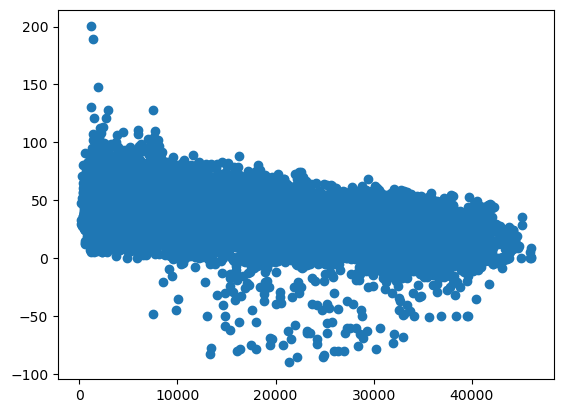

In [123]:
valid_mask = df_sample['DE_wind_generation'].notna() & df_sample['DE_price_ahead'].notna()
plt.scatter(df_sample[valid_mask]['DE_wind_generation'], df_sample[valid_mask]['DE_price_ahead'])

In [124]:
df_sample.dropna()

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
32856,2018-09-30 23:00:00+00:00,2018-10-01 00:00:00+01:00,6042.0,56.10
32857,2018-10-01 00:00:00+00:00,2018-10-01 01:00:00+01:00,6021.0,51.41
32858,2018-10-01 01:00:00+00:00,2018-10-01 02:00:00+01:00,6342.0,47.38
32859,2018-10-01 02:00:00+00:00,2018-10-01 03:00:00+01:00,7144.0,47.59
32860,2018-10-01 03:00:00+00:00,2018-10-01 04:00:00+01:00,7855.0,51.61
...,...,...,...,...
50395,2020-09-30 18:00:00+00:00,2020-09-30 19:00:00+01:00,8526.0,55.34
50396,2020-09-30 19:00:00+00:00,2020-09-30 20:00:00+01:00,10654.0,49.92
50397,2020-09-30 20:00:00+00:00,2020-09-30 21:00:00+01:00,11836.0,42.79
50398,2020-09-30 21:00:00+00:00,2020-09-30 22:00:00+01:00,12168.0,35.02


### Split sample into train, validation, and test data

In [125]:
# make price ahead data a pandas series with the timestamp as the index
series_sample = df_sample[['cet_cest_timestamp', 'DE_price_ahead']].set_index('cet_cest_timestamp')['DE_price_ahead'].sort_index()

# turn it into a TimeSeries object
ts_sample = TimeSeries.from_series(series_sample.dropna(), freq='H')
ts_sample

The provided DatetimeIndex was associated with a timezone (tz), which is currently not supported. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(pytz.FixedOffset(60))` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/home/atleeri/repositories/forecast-electricity-markets/.pixi/envs/default/lib/python3.12/site-packages/darts/timeseries.py:5146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)


,DE_price_ahead
cet_cest_timestamp,
2018-10-01 00:00:00,56.10
2018-10-01 01:00:00,51.41
2018-10-01 02:00:00,47.38
2018-10-01 03:00:00,47.59
2018-10-01 04:00:00,51.61
...,...
2020-09-30 19:00:00,55.34
2020-09-30 20:00:00,49.92
2020-09-30 21:00:00,42.79


In [112]:
# split into train, validation, and test data
ts_train, ts_val_and_test = ts_sample.split_after(0.7)
ts_val, ts_test = ts_val_and_test.split_after(0.5)
len(ts_train), len(ts_val), len(ts_test)

(12281, 2632, 2631)

<Axes: xlabel='cet_cest_timestamp'>

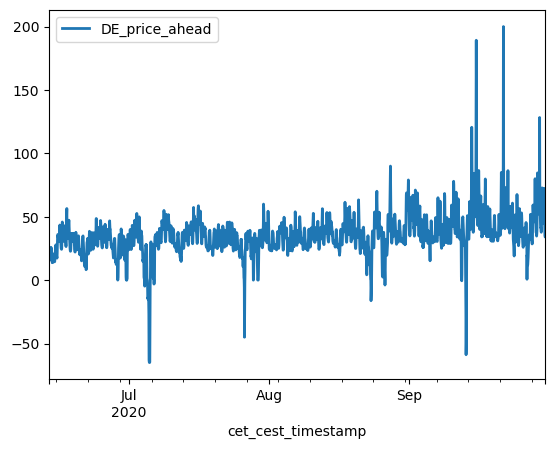

In [39]:
ts_test.plot()

#### Check seasonality

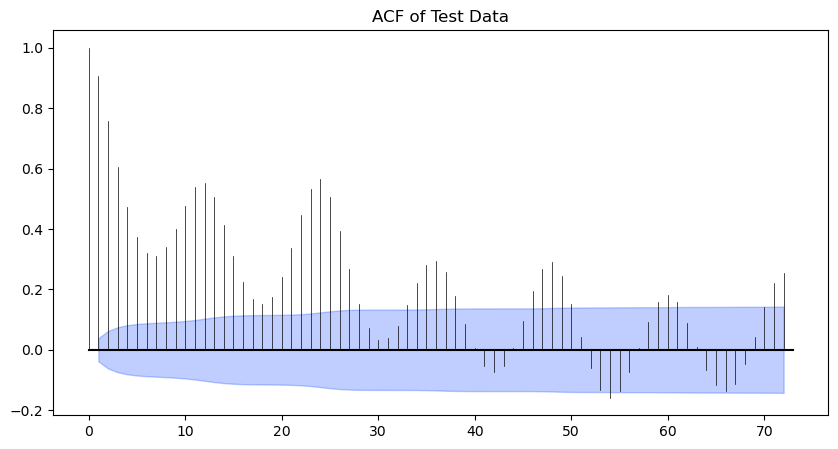

In [109]:
# Look at autocorrelation up to 72 hours
plot_acf(ts_test, max_lag=72, alpha=0.05)
plt.title('ACF of Test Data')
plt.show()


In [110]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(ts_test, m=m, alpha=0.05)
    if is_seasonal:
        print(f"There is seasonality of order {period}.")

There is seasonality of order 12.


#### Forecast with NaiveSeasonal model

In [115]:
K=12
model = NaiveSeasonal(K) #AutoARIMA(seasonal=True)
model.fit(ts_train)
y_pred = model.predict(len(ts_test))


best_shift = 0
best_mse = float('inf')
for shift in range(0,K,2):
    # Shift predictions
    shifted_values = np.roll(y_pred.values(), shift, axis=0)
    y_pred_shifted = TimeSeries.from_times_and_values(
        times=y_pred.time_index,
        values=shifted_values
    )
    
    # Calculate MSE
    mse_val = np.mean((ts_test.values()- y_pred_shifted.values())**2)
    
    if mse_val < best_mse:
        best_mse = mse_val
        best_shift = shift
    
    print(f"Shift={shift}: MSE={mse_val:.2f}")

print(f"\nBest shift: {best_shift} hours with MSE={best_mse:.2f}")

# Apply the best shift
final_pred = TimeSeries.from_times_and_values(
    times=y_pred.time_index,
    values=np.roll(y_pred.values(), best_shift, axis=0)
)

Shift=0: MSE=358.78
Shift=2: MSE=308.66
Shift=4: MSE=250.54
Shift=6: MSE=234.93
Shift=8: MSE=299.75
Shift=10: MSE=364.86

Best shift: 6 hours with MSE=234.93


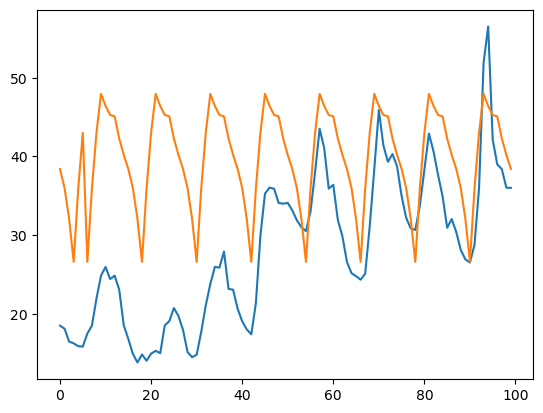

In [ ]:
plt.plot(ts_test.values()[:100,0])
plt.plot(final_pred.values()[:100,0])

### Manual Moving Average

In [135]:
df_small_sample = df_sample.dropna()[:200]

window_size = 10
forecast = []

# calculate moving average forecast
for i in range(len(df_small_sample)):
    pred_mov_avg = df_small_sample['DE_price_ahead'][i:(i+window_size)].mean()
    forecast.append(pred_mov_avg)

# add padding at the start to compensate for shift to the left. Ignore padded region when comparing
forecast = [0]*int(window_size / 2) + forecast
forecast

[0,
 0,
 0,
 0,
 0,
 np.float64(63.876999999999995),
 np.float64(65.43),
 np.float64(66.604),
 np.float64(67.89),
 np.float64(68.749),
 np.float64(68.888),
 np.float64(67.312),
 np.float64(65.622),
 np.float64(64.11800000000001),
 np.float64(63.66199999999999),
 np.float64(62.875000000000014),
 np.float64(61.098),
 np.float64(59.42900000000001),
 np.float64(57.65500000000001),
 np.float64(56.547000000000004),
 np.float64(55.657000000000004),
 np.float64(54.726),
 np.float64(53.061),
 np.float64(50.497),
 np.float64(47.81000000000001),
 np.float64(46.997),
 np.float64(48.432),
 np.float64(50.821999999999996),
 np.float64(52.025),
 np.float64(52.364),
 np.float64(52.573),
 np.float64(52.58200000000001),
 np.float64(51.28399999999999),
 np.float64(49.63),
 np.float64(47.891000000000005),
 np.float64(44.798),
 np.float64(41.845),
 np.float64(39.661),
 np.float64(39.111000000000004),
 np.float64(38.805),
 np.float64(37.39),
 np.float64(35.597),
 np.float64(32.626000000000005),
 np.float64(3

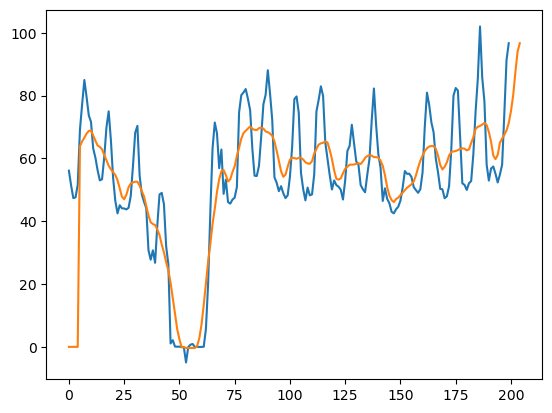

In [139]:
plt.plot(df_small_sample['DE_price_ahead'].values)
plt.plot(forecast)